In [294]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import IPython
IPython.auto_scroll_threshold = 9999;
%matplotlib inline
pd.options.display.max_columns = 9999
import glob, numpy, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, subprocess
import sys
import Plot_lakes_results as plot
reload(plot)
import matplotlib as mpl
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['font.size'] = 12
pd.get_option("display.max_columns")
os.getcwd()

'/home2/svimal/Projects/VIC/Canada'

# Function to make vegetation file 
corresponding to the soil file grid cell ID

In [2]:
def get_veggies(soil_ID):  
    global_veg_param = "/home2/svimal/Projects/VIC/Tian_0.25_global_params/vicinput/global_lai_0.25deg.txt"
    with open(global_veg_param, "r") as f:
        data_veg_global = f.readlines()
    for i, line_veg_global in enumerate(data_veg_global):
        if len(line_veg_global.split(" "))== 2 and float(line_veg_global.split(" ")[1]) != 0:
            veg_ID = int(line_veg_global.split(" ")[0]) 
            if veg_ID == soil_ID:
                veggies = []
                j=1
                while len(data_veg_global[i+j].split(" "))!= 2:
                    veggies.append(data_veg_global[i+j])
                    j=j+1
            else:
                pass
    return veggies

# Function to run VIC

In [3]:
def run_vic(filename = "/home2/svimal/Projects/VIC/Canada/Results/lake_52.625_-107.125"):
    os.chdir("/home2/svimal/Projects/VIC/Canada/")
    subprocess.check_output(["bash", "/home2/svimal/Projects/VIC/Canada/run.sh"])#, shell=True)
    df = pd.read_csv(filename, sep='\t', names = ["YEAR", "MONTH" ,"DAY" , "ICE_FRACT", "DEPTH","ICE_HEIGHT" ,"SURF_AREA", "VOLUME"])
    simSeries = list(soil.DEPTH.values)
    return simSeries

# Function to plot observation and Simulation at Redberry Lake

In [291]:
def plot_redberry(text):
    # Redberry Observations
    redberry_file = "/home2/svimal/Data/Canada/Redberry_Levels/Daily__Sep-6-2017_01_25_49AM.csv"
    df_obs = pd.read_csv(redberry_file, sep = "," , skiprows=2)
    df_obs = df_obs.drop(df_obs.columns[[0,1,2,6,8,10,12,14,16,18,20,22,24,26,28]], axis=1)
    df_obs.columns = "year day 1 2 3 4 5 6 7 8 9 10 11 12".split(" ")
    df_obs.index = df_obs["year"]
    df_obs["day 1 2 3 4 5 6 7 8 9 10 11 12".split(" ")]
    # Convert the data into a one line series with 
    s = df_obs.set_index('day', append=True).rename_axis('month', 1).stack()
    s.index = pd.to_datetime(s.reset_index().iloc[:, :3], errors='coerce')
    s = s.loc[s.index.dropna()]
    print 
    lake_f = "/home2/svimal/Projects/VIC/Canada/Results/lake_52.625_-107.125"
    df_lake = pd.read_csv(lake_f, header=None, delim_whitespace=True,
                          names = ["YEAR","MONTH" ,"DAY" , "ICE_FRACT", "DEPTH", "ICE_HEIGHT" ,"SURF_AREA", "VOLUME"])
    date = str(df_lake['YEAR'][0]) + '-' + str(df_lake['MONTH'][0])+ '-' + str(df_lake['DAY'][0])
    s = s -  s.loc['1980-1-1':'2006-12-31'].mean() + df_lake.DEPTH.mean()
    df_lake.index = pd.date_range(date, periods=len(df_lake), freq="D")
    plt.figure(dpi=150, figsize=(15,5));plt.title("Redberry " + text);
    s.plot(); df_lake.DEPTH.plot(); df_lake.DEPTH.rolling(300).mean().plot(); 
    plt.legend(["Observed","VIC Simulated", "VIC (yearly mean)"]); plt.ylim(0,max(df_lake.DEPTH)*1.1);plt.ylabel("Lake Depth (m)");
    plt.figure(dpi=150, figsize=(15,5)); plt.title("Average Depth Variation Per Year")
    df_lake.DEPTH.groupby([df_lake.index.month]).mean().plot();
    s.groupby([s.index.month]).mean().plot();plt.legend(["Simulated","Observed"]);

# Create soil and vegetation parameter files
Grid cell ID is taken from the list of files in the forcing directory

This block takes time to run (like 3 minutes) because its working on a large text file -- 0.25 degree global soil parameter file

In [55]:
def write_soil_file(soil): 
    soil.to_csv("/home2/svimal/Projects/VIC/Canada/VicSetup/Soil_Params", 
                sep=str(' '), columns=None, header=False, index=False, 
                mode='w', line_terminator='\n')

In [181]:
forcing_files = list( set(glob.glob("/home2/svimal/Projects/VIC/Canada/Forcing_Data/*")) - set(glob.glob("/home2/svimal/Projects/VIC/Canada/Forcing_Data/*.jpg")))
soil_param = "/home2/svimal/Projects/VIC/Tian_0.25_global_params/vicinput/global_soil_calib_smoothed_tz"

with open(soil_param, "r") as f:
    data_global = f.readlines()

soil_param_file = []
veg_param_file = []
for f in forcing_files:
    lat = float(f.split("_")[-2])
    lon = float(f.split("_")[-1]) # .strip("-")
    #print lat, lon
    for line_global in data_global:
        lat_global = float(line_global.split()[2])
        lon_global = float(line_global.split()[3]) 
        dist = numpy.sqrt((lon - lon_global)**2 + (lat - lat_global)**2 )    
        if dist < 0.2: # Find the nearest global grid to each local grid
            #print dist, lat, lon
            soil_param_file.append(line_global.split(line_global.split(" ")[2])[0] \
            + str(lat) + " "+ str(lon) + line_global.split(line_global.split(" ")[3])[1][0:-2])
            soil_ID = line_global.split(" ")[1]
            veggies = get_veggies(int(soil_ID))
            no_tiles = str(len(veggies)/2)
            veg_param_file.append(soil_ID+ " " + no_tiles + "\n")
            veg_param_file.extend(veggies)

# Write the veg param file


In [28]:
veg_param = "/home2/svimal/Projects/VIC/Canada/VicSetup/Veg_Params"
with open(veg_param, "w") as f:
    for line in veg_param_file:
        f.write(line)

# Make lake parameter file

In [30]:
#18.540 0.17193 18.430 0.14833 18.240 0.12472 17.894 0.10110 17.179 0.07748 16.540 0.05387 14.905 0.04665 13.270 0.03809 11.635 0.02693
redberry_candle = "172764 4 9 14.55 0.01 15 1\n18.0 0.1644 16.0 0.1444 14.0 0.1203 13.0 0.1102 12.0 0.1010 11.0 0.0910 10.0 0.0850 9.0 0.07515 8.7 0.06509 8.54 0.05193 8.43 0.040 7.894 0.0311 6.54 0.02387 5.905 0.01665 4.27 0.005\n\
177308 0 9 15 0.01 15.3924 1\n18.0 0.2644 16.0 0.2444 14.0 0.2203 13.0 0.2102 12.0 0.2010 11.0 0.1910 10.0 0.1850 9.0 0.17515 8.7 0.16509 8.54 0.15193 8.43 0.140 7.894 0.1311 6.54 0.12387 5.905 0.11665 4.27 0.050\n"
with open("/home2/svimal/Projects/VIC/Canada/VicSetup/Lake_Params_NoSEA", "w") as l:
    l.write(redberry_candle)
    for line in soil_param_file:
        ID = line.split()[1]
        l.write(ID + " -1 9 15 0.01 15.3924 1\n18.0 0.2644 16.0 0.2444 14.0 0.2203 13.0 0.2102 12.0 0.2010 11.0 0.1910 10.0 0.1850 9.0 0.17515 8.7 0.16509 8.54 0.15193 8.43 0.140 7.894 0.1311 6.54 0.12387 5.905 0.11665 4.27 0.050\n")

# Prepare soil parameter file for run
so it's easy to change the parameter values while trying out different VIC runs

In [198]:
line_global.split(line_global.split(" ")[2])[0] \
            + str(lat) + " "+ str(lon) + line_global.split(line_global.split(" ")[3])[1][0:-2]
soil = pd.DataFrame([x.split(" ") for x in soil_param_file])
names  =  "RunNo, GridID, Lat, Lon, Infilt, Ds, DsMax, Ws, c, Exp1, Exp2, Exp3, Ksat1, Ksat2, Ksat3, Phi1, Phi2, Phi3, \
init_moist1, init_moist2, init_moist3, avg_elev, soilD1, soilD2, soilD3, SoilT, SoilTempD, BubP1, BubP2, BubP3, \
BD1, BD2, BD3, QCont1, QCont2, QCont3, SoilDen1, SoilDen2, SoilDen3, GMT, SMCP1, SMCP2, SMCP3, WP1, WP2, WP3, \
SoilRough, SR_Snow, AvgPrecip, ResMois1, ResMois2, ResMois3, FS".split(", ")
soil.columns = names
soil.RunNo = 0
# Put Redberry Lake and Candle Lake on top
#print soil.loc[(soil['Lat'] == "52.625") & soil['Lon'].isin(["-107.125"])].index[0]
#print soil.loc[(soil['Lat'] == "53.875") & soil['Lon'].isin(["-105.375"])].index[0]
Candle_id = list(soil.loc[(soil['Lat'] == "53.875") & soil['Lon'].isin(["-105.375"])].index)[0]
Redberry_id = list(soil.loc[(soil['Lat'] == "52.625") & soil['Lon'].isin(["-107.125"])].index)[0]
soil.loc[0], soil.loc[Redberry_id] = soil.loc[Redberry_id], soil.loc[0]
soil.loc[1], soil.loc[Candle_id] = soil.loc[Candle_id], soil.loc[1]
# Activate only specific grids (Redberry and Candle)
soil.at[0,"RunNo"] = 1 # Run Redberry lake
#soil.at[1,"RunNo"] = 1 # Candle lake
soil.head(2)

,RunNo,GridID,Lat,Lon,Infilt,Ds,DsMax,Ws,c,Exp1,Exp2,Exp3,Ksat1,Ksat2,Ksat3,Phi1,Phi2,Phi3,init_moist1,init_moist2,init_moist3,avg_elev,soilD1,soilD2,soilD3,SoilT,SoilTempD,BubP1,BubP2,BubP3,BD1,BD2,BD3,QCont1,QCont2,QCont3,SoilDen1,SoilDen2,SoilDen3,GMT,SMCP1,SMCP2,SMCP3,WP1,WP2,WP3,SoilRough,SR_Snow,AvgPrecip,ResMois1,ResMois2,ResMois3,FS
0,1,172764,52.625,-107.125,0.2552,0.5754,23.0276,0.4332,2.0000,78.3658,78.3658,78.3658,522.2877,573.8089,573.8089,-999,-999,-999,84.3562,618.2278,184.8688,541.4211,0.3000,5.9554,5.5306,0.4627,4.0000,32.8084,33.3855,33.3855,0.3682,0.3145,0.3145,1279.0658,1314.2191,1314.2191,2313.9224,2557.2896,2557.2896,-7.0000,0.6285,0.5995,0.5995,0.3802,0.3781,0.3781,0.0010,0.0005,341.3823,0.0767,0.0844,0.0844,1
1,0,177308,53.875,-105.375,0.1173,0.7581,25.3116,0.5993,2.0000,55.8259,55.8259,55.8259,463.4129,1672.7118,1672.7118,-999,-999,-999,67.9547,434.7312,190.5796,514.5722,0.3000,3.5922,4.4997,-0.6349,4.0000,36.8923,26.3928,26.3928,0.3464,0.3425,0.3425,1251.6874,1309.5581,1309.5581,2251.2029,2755.7004,2755.7004,-7.0000,0.5100,0.5789,0.5789,0.3021,0.3745,0.3745,0.0010,0.0005,445.1511,0.0712,0.0903,0.0903,1



# VIC runs

In [292]:
# Replace the primitive loop thing with Shuffle Complex Evolutionary Algoritm based calibration
'''
import spotpy
spotpy.parameter.Uniform

i = 0
for b_infilt in np.arange(0.00001, 0.2, 0.05):
    for Ds in np.arange(0.00001, 0.1, 0.05):
        for Ws in np.arange(0.2, 0.5, 0.1):
            for D2 in np.arange(0.7, 1, 0.1):
                for D3 in  np.arange(0.7, 2.5, 0.2):
                    for DsMax in  np.arange(12, 18, 0.5):
                        i = i+1
print i
'''

'\nimport spotpy\nspotpy.parameter.Uniform\n\ni = 0\nfor b_infilt in np.arange(0.00001, 0.2, 0.05):\n    for Ds in np.arange(0.00001, 0.1, 0.05):\n        for Ws in np.arange(0.2, 0.5, 0.1):\n            for D2 in np.arange(0.7, 1, 0.1):\n                for D3 in  np.arange(0.7, 2.5, 0.2):\n                    for DsMax in  np.arange(12, 18, 0.5):\n                        i = i+1\nprint i\n'

,RunNo,GridID,Lat,Lon,Infilt,Ds,DsMax,Ws,c,Exp1,Exp2,Exp3,Ksat1,Ksat2,Ksat3,Phi1,Phi2,Phi3,init_moist1,init_moist2,init_moist3,avg_elev,soilD1,soilD2,soilD3,SoilT,SoilTempD,BubP1,BubP2,BubP3,BD1,BD2,BD3,QCont1,QCont2,QCont3,SoilDen1,SoilDen2,SoilDen3,GMT,SMCP1,SMCP2,SMCP3,WP1,WP2,WP3,SoilRough,SR_Snow,AvgPrecip,ResMois1,ResMois2,ResMois3,FS
0,1,172764,52.625,-107.125,0.45,0.011,0.001,0.99,2,78.3658,78.3658,78.3658,522.2877,573.8089,573.8089,-999,-999,-999,60,150,300,541.4211,0.3,0.9,1.5,0.4627,4.0000,32.8084,33.3855,33.3855,0.3682,0.3145,0.3145,1279.0658,1314.2191,1314.2191,2313.9224,2557.2896,2557.2896,-7.0000,0.6285,0.5995,0.5995,0.3802,0.3781,0.3781,0.0010,0.0005,341.3823,0.0767,0.0844,0.0844,0
1,0,177308,53.875,-105.375,0.45,0.011,0.001,0.99,2,55.8259,55.8259,55.8259,463.4129,1672.7118,1672.7118,-999,-999,-999,60,150,300,514.5722,0.3,0.9,1.5,-0.6349,4.0000,36.8923,26.3928,26.3928,0.3464,0.3425,0.3425,1251.6874,1309.5581,1309.5581,2251.2029,2755.7004,2755.7004,-7.0000,0.5100,0.5789,0.5789,0.3021,0.3745,0.3745,0.0010,0.0005,445.1511,0.0712,0.0903,0.0903,0


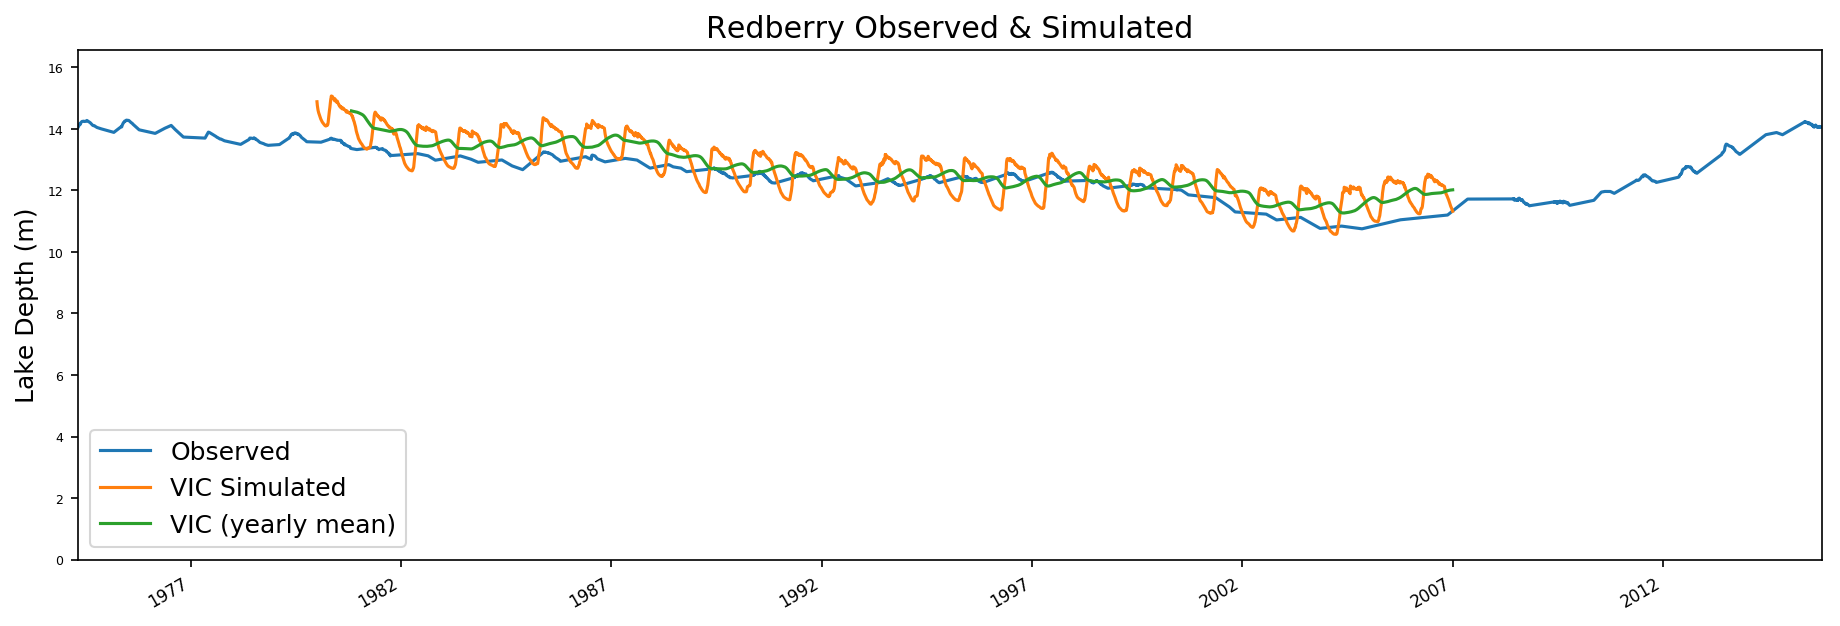

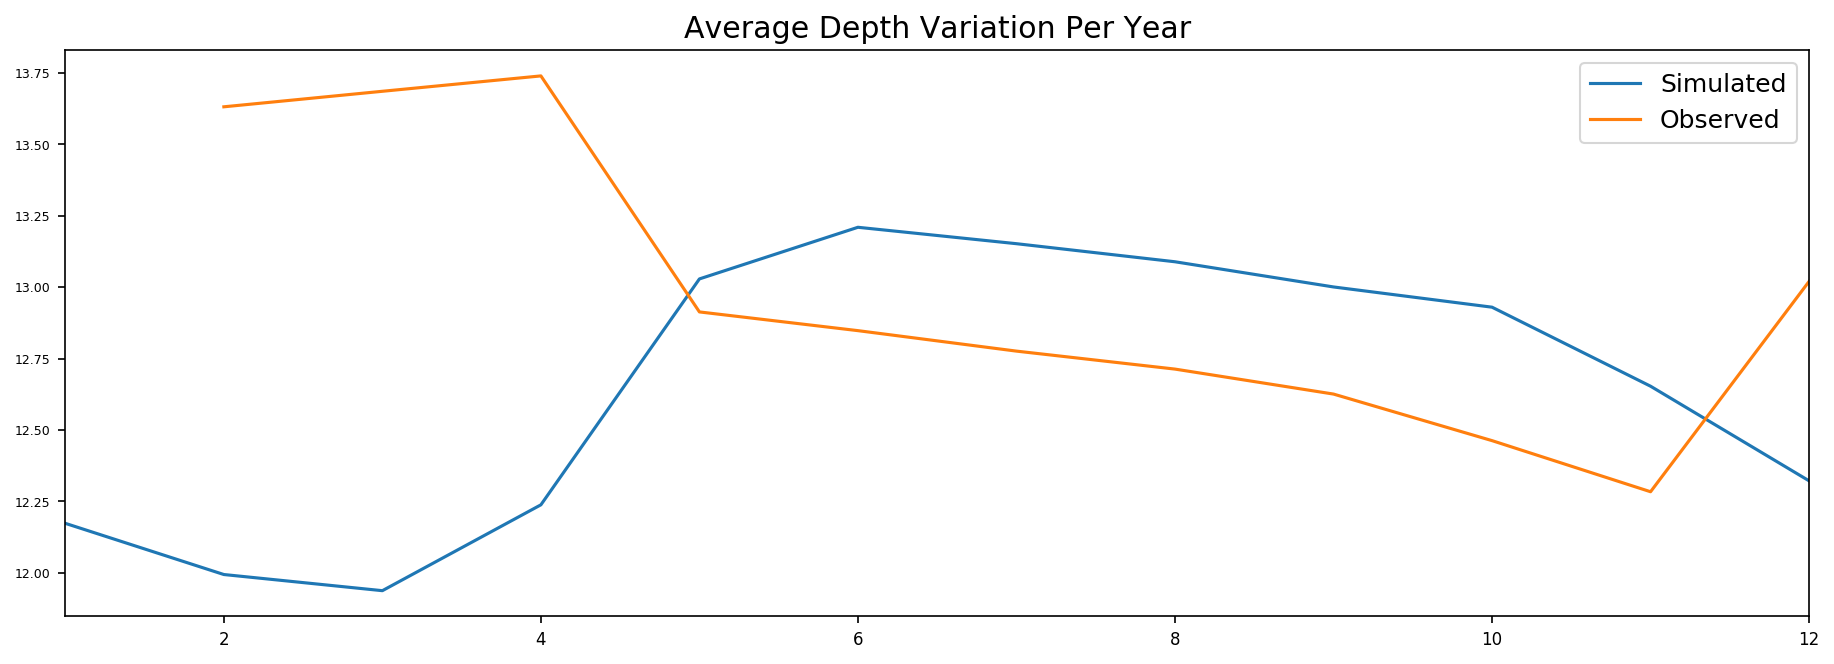

In [293]:
soil.DsMax = 0.001
soil.Infilt = 0.45
soil.Ds = 0.011
soil.Ws = 0.99
soil.c = 2
soil.soilD1 = 0.3
soil.soilD2 = 0.9
soil.soilD3 = 1.5
soil.init_moist1 = 60
soil.init_moist2 = 150
soil.init_moist3 = 300
soil.FS = 0
write_soil_file(soil)
run_vic()
plot_redberry("Observed & Simulated")
soil.head(2)

# Plot Fluxes and SWE

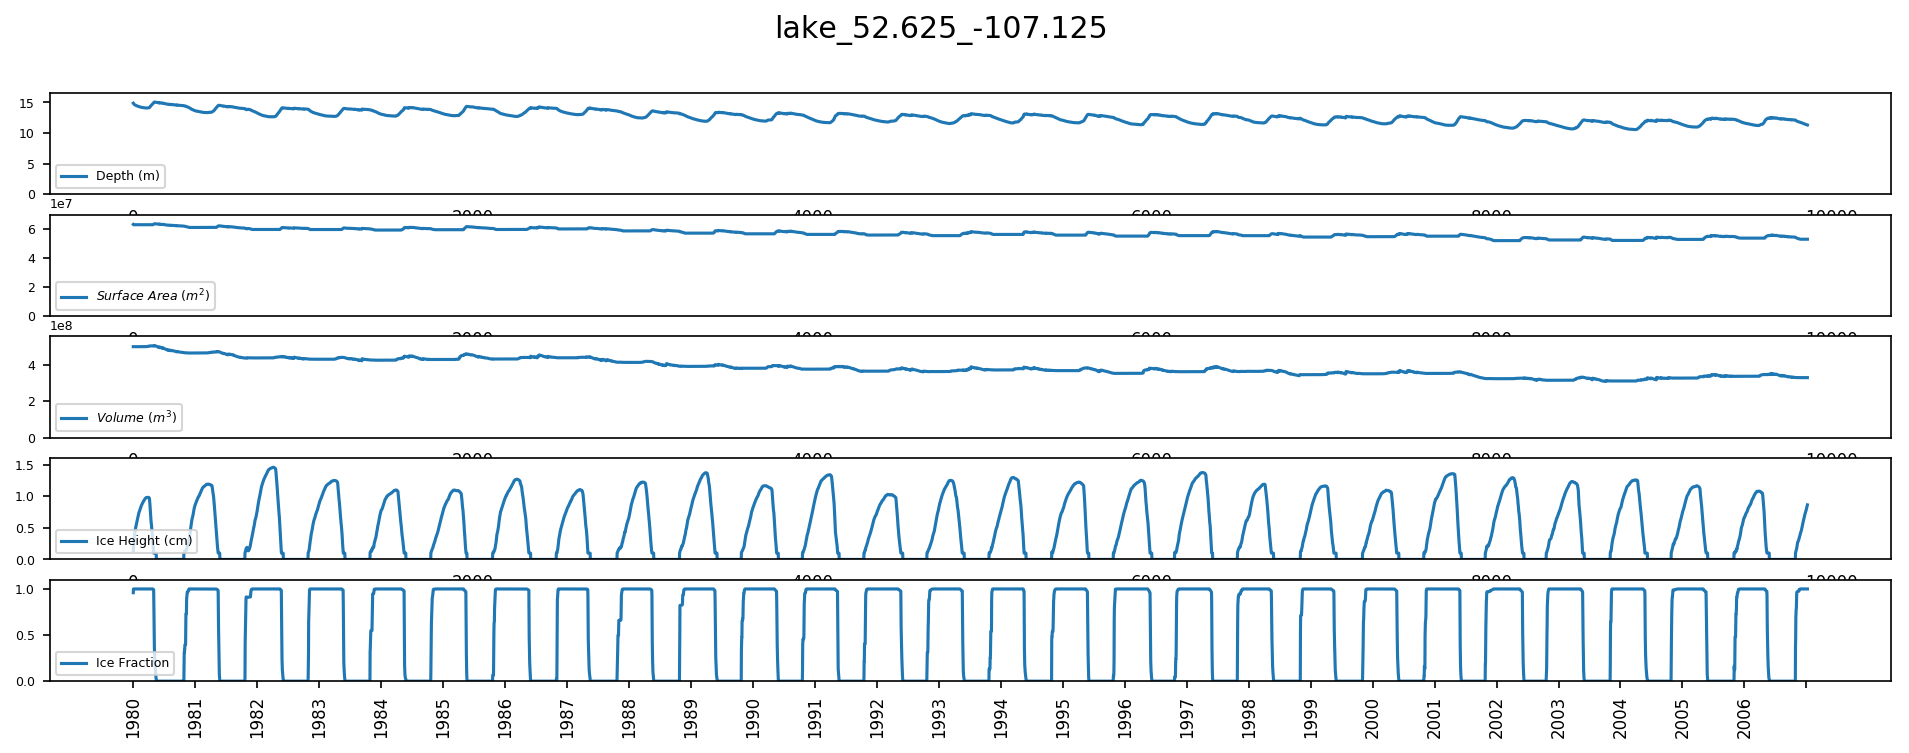

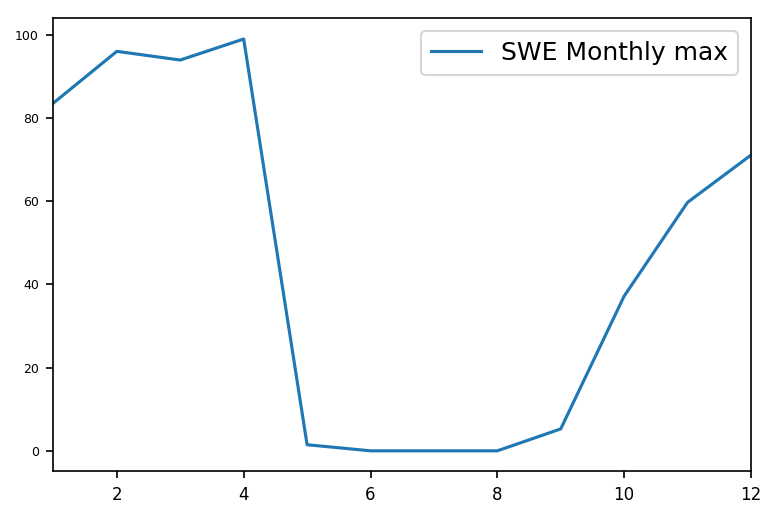

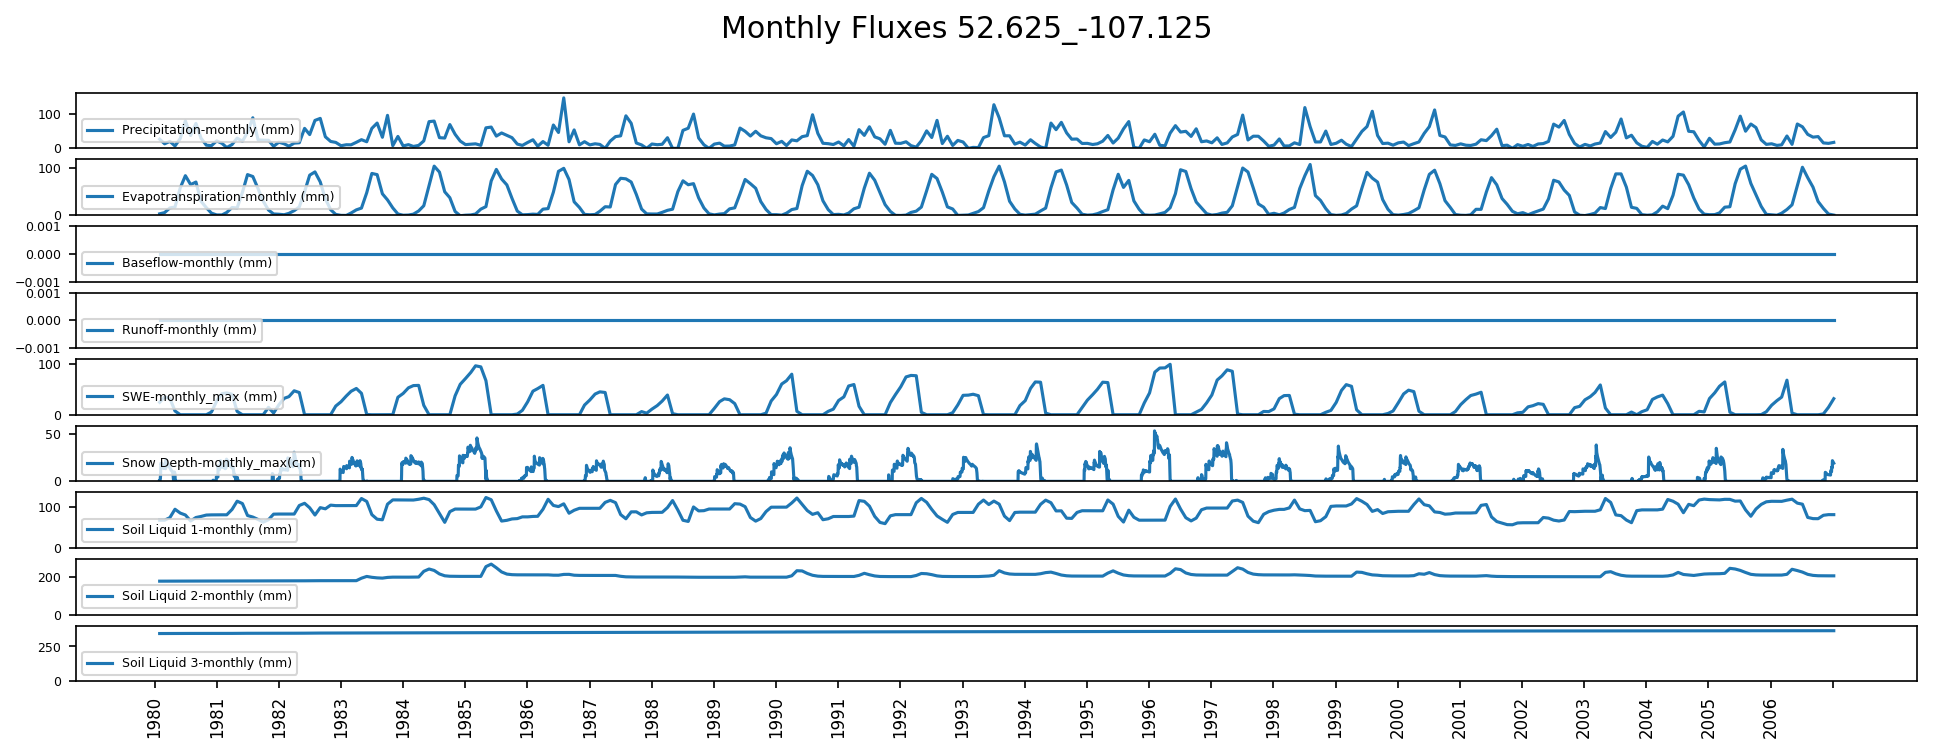

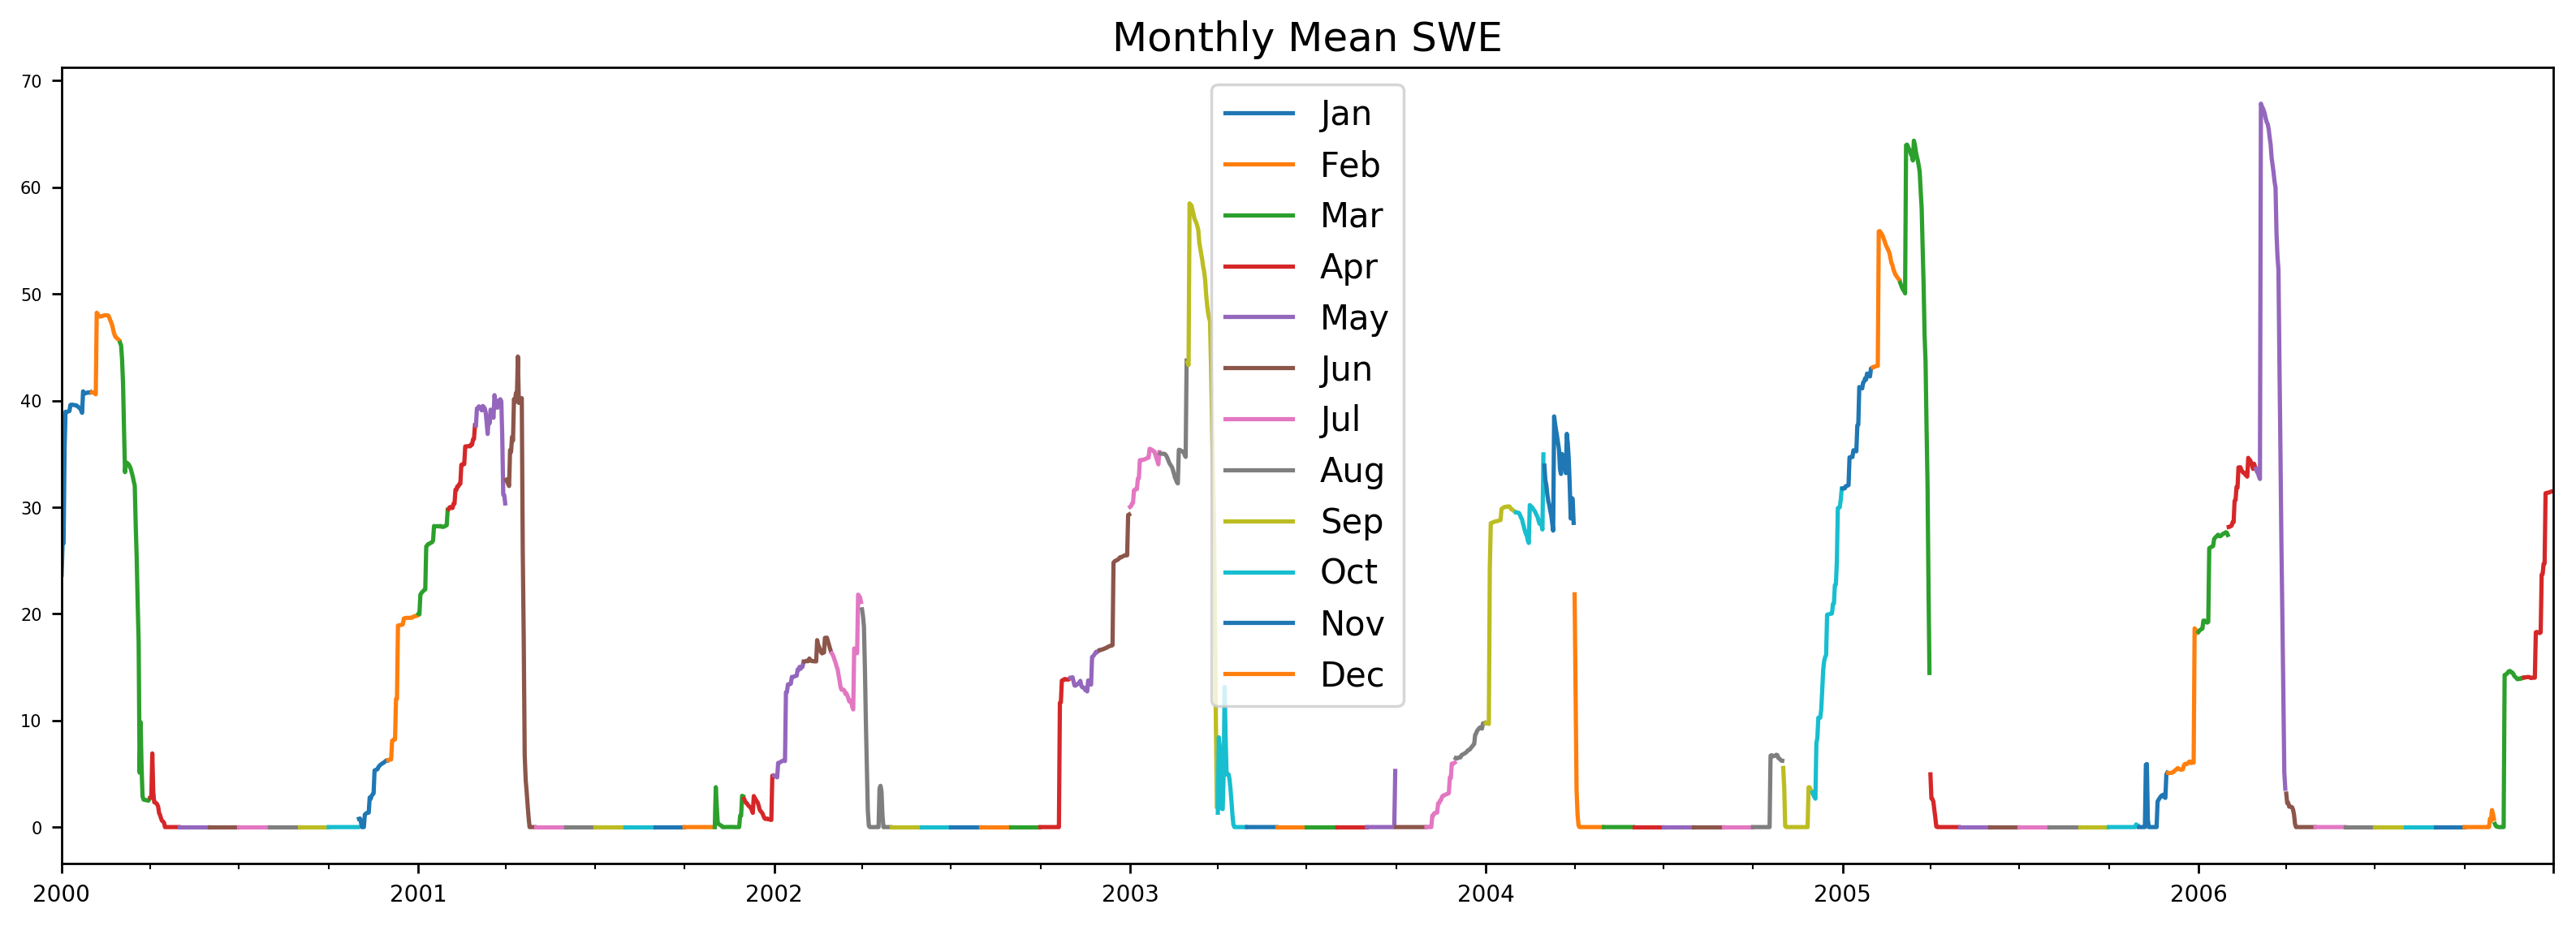

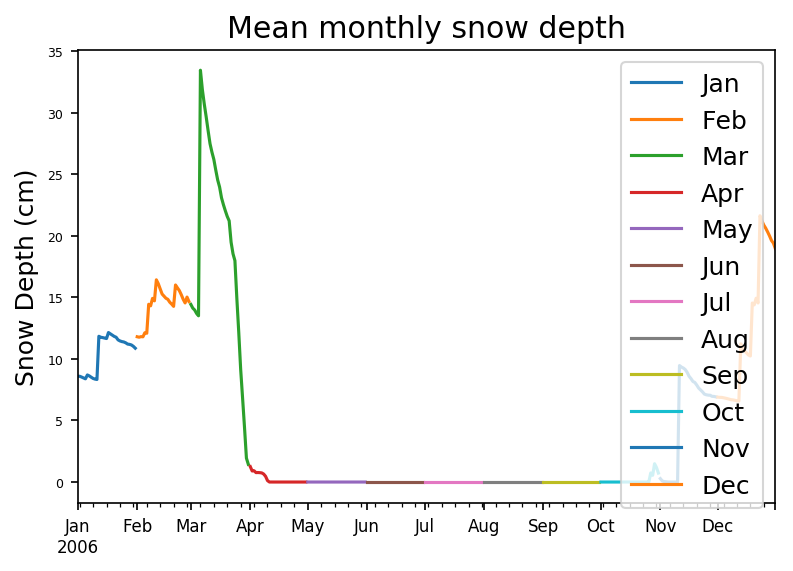

In [289]:
Redberry = [52.625, -107.125]

sys.path.insert(0, '/home2/svimal/Projects/VIC/Canada/') # or: sys.path.insert(0, os.getcwd())
os.chdir("/home2/svimal/Projects/VIC/Canada/Results")
plot.plot_lake_snow("Redberry","fluxes_"+str(Redberry[0])+"_"+str(Redberry[1]), 
                               "snow_"+str(Redberry[0])+"_"+str(Redberry[1]), 
                               "lake_"+str(Redberry[0])+"_"+str(Redberry[1]))